#Gesture Identification from Inertial Sensors

##Download of segmented data

In [0]:
import urllib.request
import os.path
import numpy as np

if not os.path.exists('X_janelas.npy'):
  urllib.request.urlretrieve('https://github.com/xpiolx/stanvcic_data/raw/master/X_janelas.npy?raw=true', 
                             'X_janelas.npy')
if not os.path.exists('Y_janelas.npy'):
  urllib.request.urlretrieve('https://github.com/xpiolx/stanvcic_data/blob/master/Y_janelas.npy?raw=true', 
                             'Y_janelas.npy')  
X = np.load('X_janelas.npy', allow_pickle=True)
y = np.load('Y_janelas.npy', allow_pickle=True)
train_len = int(y.shape[0]*8/10)
X_train, y_train, X_test, y_test = X[:train_len], y[:train_len], X[train_len:], y[train_len:]

##Feature Extraction Models

In [0]:
from sklearn.base import TransformerMixin
import numpy as np
import scipy.stats as stats

# roor mean square
def rms(x):
  x = np.array(x)
  return np.sqrt(np.mean(np.square(x)))
# square root amplitude
def sra(x):
  x = np.array(x)
  return np.mean(np.sqrt(np.absolute(x)))**2
# peak to peak value
def ppv(x):
  x = np.array(x)
  return np.max(x)-np.min(x)
# crest factor
def cf(x):
  x = np.array(x)
  return np.max(np.absolute(x))/rms(x)
# impact factor
def ifa(x):
  x = np.array(x)
  return np.max(np.absolute(x))/np.mean(np.absolute(x))
# margin factor
def mf(x):
  x = np.array(x)
  return np.max(np.absolute(x))/sra(x)
# shape factor
def sf(x):
  x = np.array(x)
  return rms(x)/np.mean(np.absolute(x))
# kurtosis factor
def kf(x):
  x = np.array(x)
  return stats.kurtosis(x)/(np.mean(x**2)**2)

class StatisticalTime(TransformerMixin):
  def __init__(self):
    pass
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    features = None
    for signal in range(X_train.shape[2]):
      feats = np.array([[rms(x), sra(x), stats.kurtosis(x), stats.skew(x), ppv(x), cf(x), ifa(x), mf(x), sf(x), kf(x)] for x in X[:,:,signal]])
      if features is None:
        features = feats
      else:
        features = np.concatenate((features,feats),axis=1)
    return features
  
class StatisticalFrequency(TransformerMixin):
  def __init__(self):
    pass
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    features = None
    for signal in range(X_train.shape[2]):
      featarray = []
      for x in X[:,:,signal]:
        fx = np.absolute(np.fft.fft(x))
        fc = np.mean(fx)
        featarray.append([fc, rms(fx), rms(fx-fc)])
      feats = np.array(featarray)
      if features is None:
        features = feats
      else:
        features = np.concatenate((features,feats),axis=1)
    return features

class Statistical(TransformerMixin):
  def __init__(self):
    pass
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    st = StatisticalTime()
    stfeats = st.transform(X)
    sf = StatisticalFrequency()
    sffeats = sf.transform(X)
    return np.concatenate((stfeats,sffeats),axis=1)
   
import pywt
class WaveletPackage(TransformerMixin):
  def __init__(self):
    pass
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    def Energy(coeffs, k):
      return np.sqrt(np.sum(np.array(coeffs[-k]) ** 2)) / len(coeffs[-k])
    def getEnergy(wp):
      coefs = np.asarray([n.data for n in wp.get_leaf_nodes(True)])
      return np.asarray([Energy(coefs,i) for i in range(2**wp.maxlevel)])
    features = None
    for signal in range(X_train.shape[2]):
      feats = np.array([getEnergy(pywt.WaveletPacket(data=x, wavelet='db4', mode='symmetric', maxlevel=4)) for x in X[:,:,signal]])
      if features is None:
        features = feats
      else:
        features = np.concatenate((features,feats),axis=1)
    return features

class Heterogeneous(TransformerMixin):
  def __init__(self):
    pass
  def fit(self, X, y=None):
    return self
  def transform(self, X, y=None):
    st = StatisticalTime()
    stfeats = st.transform(X)
    sf = StatisticalFrequency()
    sffeats = sf.transform(X)
    wp = WaveletPackage()
    wpfeats = wp.transform(X)
    return np.concatenate((stfeats,sffeats,wpfeats),axis=1)


## Adaptation to no extract features

In [0]:
class SignalAdapter(TransformerMixin):
    def __init__(self):
      pass
    def fit(self, X, y=None):
      return self
    def transform(self, X, y=None):
      return X.reshape(X.shape[0],-1)

## Function to plot confusion matrix

In [0]:
import itertools
from sklearn.metrics import confusion_matrix
from matplotlib import pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greys):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    #plt.title(title)
    #plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('Classe verdadeira')
    plt.xlabel('Classe estimada')


##3-dimentional Standar Scaler

In [0]:
import numpy as np
from sklearn.base import TransformerMixin
from sklearn.preprocessing import StandardScaler


class NDStandardScaler(TransformerMixin):
    def __init__(self):
        self._scaler = StandardScaler(copy=True)
        self._orig_shape = None

    def fit(self, X, y=None):
        X = np.array(X)
        # Save the original shape to reshape the flattened X later
        # back to its original shape
        if len(X.shape) > 1:
            self._orig_shape = X.shape[1:]
        X = self._flatten(X)
        self._scaler.fit(X)
        return self

    def transform(self, X, y=None):
        X = np.array(X)
        X = self._flatten(X)
        X = self._scaler.transform(X)
        X = self._reshape(X)
        return X

    def _flatten(self, X):
        # Reshape X to <= 2 dimensions
        if len(X.shape) > 2:
            n_dims = np.prod(self._orig_shape)
            X = X.reshape(-1, n_dims)
        return X

    def _reshape(self, X):
        # Reshape X back to it's original shape
        if len(X.shape) >= 2:
            X = X.reshape(-1, *self._orig_shape)
        return X


## F1-Score macro for Keras

In [0]:
from keras import backend as K
def f1_score_macro(y_true,y_pred):
    def recall(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall
    def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))


## ANN definition

In [0]:
from keras import layers
from keras import Input
from keras.models import Model
from keras.callbacks import EarlyStopping,ReduceLROnPlateau
from keras.utils import to_categorical

from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.utils import shuffle
class ANNConv1D(BaseEstimator, ClassifierMixin):
  def __init__(self, filters=16, kernel_size=22, shape=X_train.shape):
    self.shape = shape
    self.filters = filters
    self.kernel_size = kernel_size

  def fit(self, X, y=None):
    y_cat = to_categorical(y)
    signal_input = Input(shape=(self.shape[1],self.shape[-1]),
                         dtype='float32', name='signal')
    x = layers.Conv1D(filters=self.filters, 
                      kernel_size=self.kernel_size, 
                      activation='relu', 
                      name='conv1d_1')(signal_input)
    x = layers.MaxPooling1D(self.kernel_size, 
                            name='max_pooling1d_1')(x)
    x = layers.Flatten(name='flatten')(x)
    condition_output = layers.Dense(7,activation='softmax',
                                    name='condition')(x)
    self.model = Model(signal_input, condition_output) 
    self.model.compile(optimizer='rmsprop',
                       loss='mean_squared_error', 
                       metrics=['accuracy',f1_score_macro])
      
    self.history = self.model.fit(X ,y_cat, epochs=50, 
                                  validation_split=0.3,
                                  callbacks=[EarlyStopping(patience=3),
                                             ReduceLROnPlateau()],
                                  verbose=1)
    return self

  def predict(self, X, y=None):
    return np.argmax(self.model.predict(X), axis=1)


## Setup of pipelines and grid searches

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

# K-NN with Feateure Extraction
p_knn = Pipeline([('feature_extraction', Heterogeneous()),
                  ('std_scaler', StandardScaler()),
                  ('knn', KNeighborsClassifier()),
                 ])
grid_knn = GridSearchCV(p_knn, param_grid={"knn__n_neighbors": [1,3,5,7,9,11]}, 
                        cv=StratifiedKFold(3), verbose=2)

# Random Forest without Feature Extraction
p_rf = Pipeline([('signal_adapter', SignalAdapter()),
                 ('std_scaler', StandardScaler()),
                 ('rf', RandomForestClassifier()),
                ])
grid_rf = GridSearchCV(p_rf, param_grid={"rf__n_estimators": [10, 20], 
                                         "rf__max_features": [4, 8, None],
                                        },
                       cv=StratifiedKFold(3), verbose=2)

# Random Forest with Feature Extraction
p_rf_wfe = Pipeline([('feature_extraction', Heterogeneous()),
                 ('std_scaler', StandardScaler()),
                 ('rf', RandomForestClassifier()),
                ])
grid_rf_wfe = GridSearchCV(p_rf_wfe, param_grid={"rf__n_estimators": [10, 20],
                                                 "rf__max_features": [4, 8, None],
                                                },
                           cv=StratifiedKFold(3), verbose=2)

# Artificial Neural Network - Conv1d
p_ann = Pipeline([('std_scaler', NDStandardScaler()),
                  ('conv1d', ANNConv1D(shape=X_train.shape)),
                 ])
grid_ann = GridSearchCV(p_ann, 
                        param_grid={'conv1d__filters': [64, 128], 
                                    'conv1d__kernel_size': [13, 27, 55],
                                   }, 
                        cv=StratifiedKFold(3), verbose=2)

# List of Classifiers
clfs = [("K-NN with Feateure Extraction", grid_knn),
        ("Random Forest without Feature Extraction", grid_rf),
        ("Random Forest with Feature Extraction", grid_rf_wfe),
        ("Artificial Neural Network - Conv1d", grid_ann),
       ]


## Perform the experiments

In [0]:
from sklearn.metrics import f1_score, accuracy_score

class_names = list(set(y_train))
class_names = ['Neutral', 'Gesture 1', 'Gesture 2', 'Gesture 3', 'Gesture 4', 'Gesture 5', 'Gesture 6']
figprop = np.linspace(1, 0.5, 25)
tam = len(class_names) * figprop[len(class_names)]


results = {}
models = {}
genconfmat = True
results['st'] = {}
models['st'] = {}

for clfname, model in clfs:
    print(clfname, end=":\t")
    '''
    if not clfname in results['st']:
        results['st'][clfname] = []
    '''
    history = model.fit(X_train ,y_train)
    print(model.best_params_)
    '''
    y_pred = model.predict(X_test)
    results['st'][clfname].append([accuracy_score(y_test,y_pred),f1_score(y_test,y_pred,average='macro')])
    print(results['st'][clfname][-1])
    if genconfmat:
        cnf_matrix = confusion_matrix(y_test, y_pred)
        print(cnf_matrix)
        plt.figure(figsize=(tam,tam))
        plot_confusion_matrix(cnf_matrix, classes=class_names, title=clfname, normalize=False)
        plt.show()
        plot_confusion_matrix(cnf_matrix, classes=class_names, title=clfname, normalize=True)
        #plt.savefig('cnfmatrix_st'+clfname+str(fold)+'round'+str(j)+'.png')
        plt.show()
    '''


K-NN with Feateure Extraction:	Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] knn__n_neighbors=1 ..............................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] ............................... knn__n_neighbors=1, total=  30.1s
[CV] knn__n_neighbors=1 ..............................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.1s remaining:    0.0s


[CV] ............................... knn__n_neighbors=1, total=  30.3s
[CV] knn__n_neighbors=1 ..............................................
[CV] ............................... knn__n_neighbors=1, total=  30.4s
[CV] knn__n_neighbors=3 ..............................................
[CV] ............................... knn__n_neighbors=3, total=  30.3s
[CV] knn__n_neighbors=3 ..............................................
[CV] ............................... knn__n_neighbors=3, total=  30.6s
[CV] knn__n_neighbors=3 ..............................................
[CV] ............................... knn__n_neighbors=3, total=  30.7s
[CV] knn__n_neighbors=5 ..............................................
[CV] ............................... knn__n_neighbors=5, total=  30.8s
[CV] knn__n_neighbors=5 ..............................................
[CV] ............................... knn__n_neighbors=5, total=  30.2s
[CV] knn__n_neighbors=5 ..............................................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  9.2min finished


{'knn__n_neighbors': 11}
Random Forest without Feature Extraction:	Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] rf__max_features=4, rf__n_estimators=10 .........................
[CV] .......... rf__max_features=4, rf__n_estimators=10, total=   0.1s
[CV] rf__max_features=4, rf__n_estimators=10 .........................
[CV] .......... rf__max_features=4, rf__n_estimators=10, total=   0.1s
[CV] rf__max_features=4, rf__n_estimators=10 .........................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


[CV] .......... rf__max_features=4, rf__n_estimators=10, total=   0.1s
[CV] rf__max_features=4, rf__n_estimators=20 .........................
[CV] .......... rf__max_features=4, rf__n_estimators=20, total=   0.1s
[CV] rf__max_features=4, rf__n_estimators=20 .........................
[CV] .......... rf__max_features=4, rf__n_estimators=20, total=   0.1s
[CV] rf__max_features=4, rf__n_estimators=20 .........................
[CV] .......... rf__max_features=4, rf__n_estimators=20, total=   0.1s
[CV] rf__max_features=8, rf__n_estimators=10 .........................
[CV] .......... rf__max_features=8, rf__n_estimators=10, total=   0.1s
[CV] rf__max_features=8, rf__n_estimators=10 .........................
[CV] .......... rf__max_features=8, rf__n_estimators=10, total=   0.1s
[CV] rf__max_features=8, rf__n_estimators=10 .........................
[CV] .......... rf__max_features=8, rf__n_estimators=10, total=   0.1s
[CV] rf__max_features=8, rf__n_estimators=20 .........................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:   28.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... rf__max_features=4, rf__n_estimators=10, total=  30.1s
[CV] rf__max_features=4, rf__n_estimators=10 .........................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   30.1s remaining:    0.0s


[CV] .......... rf__max_features=4, rf__n_estimators=10, total=  30.4s
[CV] rf__max_features=4, rf__n_estimators=10 .........................
[CV] .......... rf__max_features=4, rf__n_estimators=10, total=  30.3s
[CV] rf__max_features=4, rf__n_estimators=20 .........................
[CV] .......... rf__max_features=4, rf__n_estimators=20, total=  30.0s
[CV] rf__max_features=4, rf__n_estimators=20 .........................
[CV] .......... rf__max_features=4, rf__n_estimators=20, total=  30.4s
[CV] rf__max_features=4, rf__n_estimators=20 .........................
[CV] .......... rf__max_features=4, rf__n_estimators=20, total=  30.3s
[CV] rf__max_features=8, rf__n_estimators=10 .........................
[CV] .......... rf__max_features=8, rf__n_estimators=10, total=  30.0s
[CV] rf__max_features=8, rf__n_estimators=10 .........................
[CV] .......... rf__max_features=8, rf__n_estimators=10, total=  30.4s
[CV] rf__max_features=8, rf__n_estimators=10 .........................
[CV] .

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  9.2min finished


{'rf__max_features': None, 'rf__n_estimators': 20}
Artificial Neural Network - Conv1d:	Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] conv1d__filters=64, conv1d__kernel_size=13 ......................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train on 1004 samples, validate on 431 samples
Epoch 1/50
1004/1004 [==============================] - 2s 2ms/step - loss: 0.0645 - acc: 0.6863 - f1_score_macro: 0.6214 - val_loss: 0.0384 - val_acc: 0.8376 - val_f1_score_macro: 0.8146
Epoch 2/50
1004/1004 [==============================] - 0s 209us/step - loss: 0.0175 - acc: 0.9472 - f1_score_macro: 0.9338 - val_loss: 0.0237 - val_acc: 0.9026 - val_f1_score_macro: 0.8915
Epoch 3/50
1004/1004 [==============================] - 0s 198us/step - loss: 0.0080 - acc: 0.9751 - f1_score_macro: 0.9735 - val_loss: 0.0193 - val_acc: 0.9118 - val_f1_score_macro: 0.9110
Epoch 4/50
1004/1004 [==============================] - 0s 184us/step - loss: 0.0041 - acc: 0.9890 - f1_score_macro: 0.9868 - val_loss: 0.0166 - val_acc: 0.9327 - val_f1_score_macro: 0.9281
Epoch 5/50
1004/1004 [==============================] - 0s 206us/step - loss: 0.0024 - acc: 0.9960 - f1_score_macro: 0.9935 - val_loss: 0.0121 - val_acc: 0.9582 - val_f1_score_macro: 0.9517
Epoch

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s


Train on 1006 samples, validate on 432 samples
Epoch 1/50
1006/1006 [==============================] - 2s 2ms/step - loss: 0.0554 - acc: 0.7346 - f1_score_macro: 0.6868 - val_loss: 0.0346 - val_acc: 0.8588 - val_f1_score_macro: 0.8551
Epoch 2/50
1006/1006 [==============================] - 0s 216us/step - loss: 0.0168 - acc: 0.9344 - f1_score_macro: 0.9265 - val_loss: 0.0208 - val_acc: 0.9190 - val_f1_score_macro: 0.9027
Epoch 3/50
1006/1006 [==============================] - 0s 184us/step - loss: 0.0067 - acc: 0.9801 - f1_score_macro: 0.9767 - val_loss: 0.0182 - val_acc: 0.9190 - val_f1_score_macro: 0.9184
Epoch 4/50
1006/1006 [==============================] - 0s 219us/step - loss: 0.0027 - acc: 0.9950 - f1_score_macro: 0.9955 - val_loss: 0.0150 - val_acc: 0.9306 - val_f1_score_macro: 0.9305
Epoch 5/50
1006/1006 [==============================] - 0s 200us/step - loss: 0.0012 - acc: 0.9990 - f1_score_macro: 0.9990 - val_loss: 0.0153 - val_acc: 0.9236 - val_f1_score_macro: 0.9240
Epoch

[Parallel(n_jobs=1)]: Done  18 out of  18 | elapsed:  1.8min finished


Train on 1509 samples, validate on 647 samples
Epoch 1/50
1509/1509 [==============================] - 3s 2ms/step - loss: 0.0301 - acc: 0.8608 - f1_score_macro: 0.8595 - val_loss: 0.0177 - val_acc: 0.9212 - val_f1_score_macro: 0.9184
Epoch 2/50
1509/1509 [==============================] - 0s 260us/step - loss: 0.0065 - acc: 0.9695 - f1_score_macro: 0.9723 - val_loss: 0.0079 - val_acc: 0.9629 - val_f1_score_macro: 0.9640
Epoch 3/50
1509/1509 [==============================] - 0s 278us/step - loss: 0.0034 - acc: 0.9867 - f1_score_macro: 0.9854 - val_loss: 0.0046 - val_acc: 0.9815 - val_f1_score_macro: 0.9815
Epoch 4/50
1509/1509 [==============================] - 0s 269us/step - loss: 0.0017 - acc: 0.9934 - f1_score_macro: 0.9937 - val_loss: 0.0041 - val_acc: 0.9830 - val_f1_score_macro: 0.9822
Epoch 5/50
1509/1509 [==============================] - 0s 272us/step - loss: 0.0030 - acc: 0.9867 - f1_score_macro: 0.9877 - val_loss: 0.0049 - val_acc: 0.9784 - val_f1_score_macro: 0.9776
Epoch

# Ploting Confusion Matrices 

K-NN with Feateure Extraction:	[0.8775510204081632, 0.7881841844064476]
[[278   0   0   0   0   0   0]
 [  1  34   4   2   2   0   0]
 [  0   7  32   0   4   0   0]
 [  4   8   2  26   3   0   0]
 [  1   7   4   8  23   1   0]
 [  1   1   0   0   0  42   0]
 [  0   0   1   0   1   4  38]]
Confusion matrix, without normalization


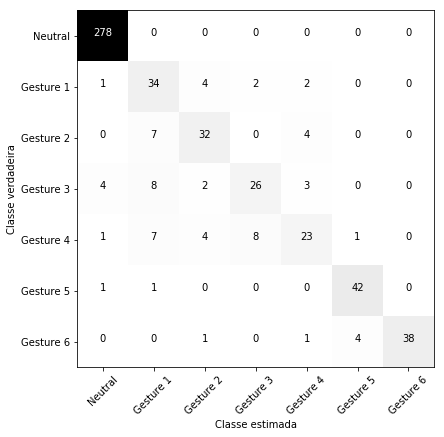

Normalized confusion matrix


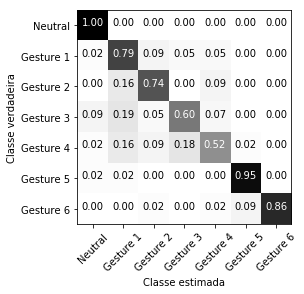

Random Forest without Feature Extraction:	[0.8478664192949907, 0.7355823188714723]
[[277   0   0   1   0   0   0]
 [  1  39   0   2   1   0   0]
 [  0  14  24   2   2   0   1]
 [  4   1   2  33   3   0   0]
 [  1   6   3  12  22   0   0]
 [  2   2   0   1   1  34   4]
 [  0   0   2   0   4  10  28]]
Confusion matrix, without normalization


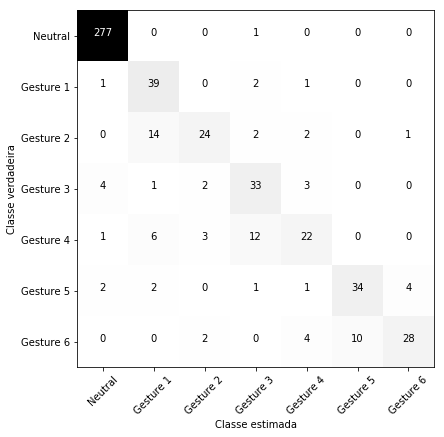

Normalized confusion matrix


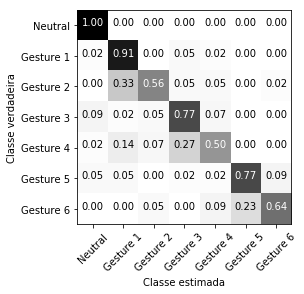

Random Forest with Feature Extraction:	[0.9387755102040817, 0.893091984721278]
[[278   0   0   0   0   0   0]
 [  0  36   3   3   1   0   0]
 [  0   0  39   0   4   0   0]
 [  0   0   0  41   1   1   0]
 [  0   0   0   2  41   1   0]
 [  1   3   0   2   2  35   1]
 [  0   0   0   0   2   6  36]]
Confusion matrix, without normalization


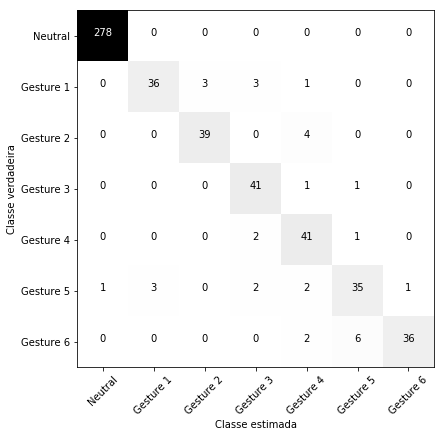

Normalized confusion matrix


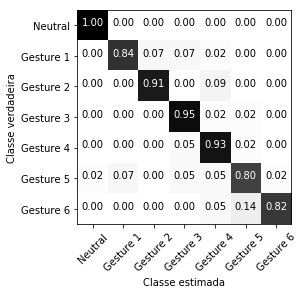

Artificial Neural Network - Conv1d:	[0.9554730983302412, 0.9231313202728417]
[[278   0   0   0   0   0   0]
 [  1  41   0   0   1   0   0]
 [  0   7  36   0   0   0   0]
 [  1   0   0  41   1   0   0]
 [  0   0   1   8  35   0   0]
 [  0   0   0   0   0  40   4]
 [  0   0   0   0   0   0  44]]
Confusion matrix, without normalization


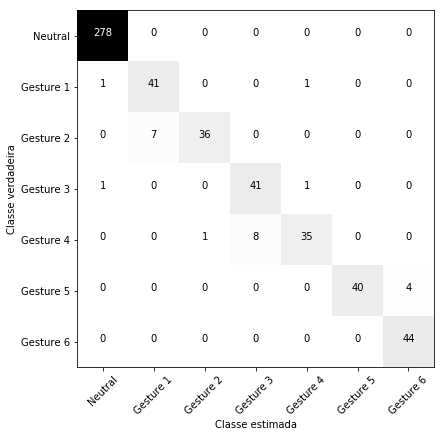

Normalized confusion matrix


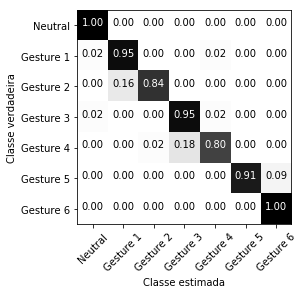

In [0]:

results = {}
models = {}
genconfmat = True
results['st'] = {}

for clfname, model in clfs:
    print(clfname, end=":\t")
    if not clfname in results['st']:
        results['st'][clfname] = []
    y_pred = model.predict(X_test)
    results['st'][clfname].append([accuracy_score(y_test,y_pred),f1_score(y_test,y_pred,average='macro')])
    print(results['st'][clfname][-1])
    if genconfmat:
        cnf_matrix = confusion_matrix(y_test, y_pred)
        print(cnf_matrix)
        plt.figure(figsize=(tam,tam))
        plot_confusion_matrix(cnf_matrix, classes=class_names, title=clfname, normalize=False)
        plt.show()
        plot_confusion_matrix(cnf_matrix, classes=class_names, title=clfname, normalize=True)
        #plt.savefig('cnfmatrix_st'+clfname+str(fold)+'round'+str(j)+'.png')
        plt.show()

## Display Results

In [0]:
print(y_test.shape)
for evaluation in results.keys():
  print("\n"+30*"#"+"\n"+evaluation+"\n"+30*"#")
  for clfname,model in clfs:
    print("\n\t"+clfname+" Results\nAccuracy\tF1-Score")
    for i,r in enumerate(results[evaluation][clfname]):
      print("{}\t".format(i+1),end="")
      print(r)

(539,)

##############################
st
##############################

	K-NN with Feateure Extraction Results
Accuracy	F1-Score
1	[0.8775510204081632, 0.7881841844064476]

	Random Forest without Feature Extraction Results
Accuracy	F1-Score
1	[0.8478664192949907, 0.7355823188714723]

	Random Forest with Feature Extraction Results
Accuracy	F1-Score
1	[0.9387755102040817, 0.893091984721278]

	Artificial Neural Network - Conv1d Results
Accuracy	F1-Score
1	[0.9554730983302412, 0.9231313202728417]
